In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Control‐ROI analysis for benson14_v1 across three contrasts:
  • Stake_comp(Low‐ vs High‐stake)
  • GL_comp   (A GAIN sh vs A LOSS sh)
  • RT_comp   (Fast vs Slow RT)

For each: compute mean±SEM, run paired t-test, print stats, and plot as a paired bar.

fig s4 in the paper
"""

import os
import glob
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# ── CONFIG ────────────────────────────────────────────────────────────────────
data_dir    = '/media/yuhui/LCT'
control_roi = 'benson14_v1'

analyses = {
    'Stake': {
        'prefix': 'stats3.blur1.rbold.',
        'mode'  : 'stake',
        'coefs' : ['ProbLH valueLH', 'ProbMM valueLH', 'ProbMM valueSH',
                'AR GAINLOSS norm', 'AR GAINLOSS sh'],
        'low'   : ['ProbLH valueLH','ProbMM valueLH'],
        'high'  : ['ProbMM valueSH'],
        'labels': ['Low‐stake','High‐stake']
    },
    'RT'   : {
        'prefix': 'stats_rt.blur1.rbold.',
        'mode'  : 'first_two',
        'labels': ['Fast','Slow']
    },
    'GL'   : {
        'prefix'   : 'stats.blur1.rbold.',
        'mode'     : 'gain_loss',
        'full_coefs': ['ProbHH valueH', 'ProbHH valueL', 'ProbLL valueH', 'ProbLL valueL',
                    'ProbMM valueH', 'ProbMM valueL', 'ProbMM valueSH',
                    'A GAIN norm', 'A GAIN sh', 'A LOSS norm', 'A LOSS sh',
                    'R GAIN norm', 'R GAIN sh', 'R LOSS norm', 'R LOSS sh'
                    ],
        'labels'   : ['A GAIN sh','A LOSS sh']
    }
}

In [3]:
# storage
t_stats = {}
means   = {}
sems    = {}
labels  = {}

pairs = {}   # NEW: keep subject-level pairs for each contrast

# ── LOOP & COMPUTE ────────────────────────────────────────────────────────────
for name, cfg in analyses.items():
    pattern = os.path.join(
        data_dir,
        "2*/bold.sft/roiProfile",
        f"{cfg['prefix']}{control_roi}.1D"
    )
    files = sorted(glob.glob(pattern))
    if not files:
        print(f"[{name}] no files found for {control_roi}")
        continue

    # load into shape (n_coefs, n_subj)
    data = np.vstack([np.loadtxt(f) for f in files]).T
    n_subj = data.shape[1]

    # pick out the two rows
    mode = cfg['mode']
    if mode == 'first_two':
        pair = data[:2, :]
    elif mode == 'stake':
        coefs = np.array(cfg['coefs'])
        li = np.where(np.isin(coefs, cfg['low']))[0]
        hi = np.where(np.isin(coefs, cfg['high']))[0]
        low_m  = data[li, :].mean(axis=0, keepdims=True)
        high_m = data[hi, :].mean(axis=0, keepdims=True)
        pair   = np.vstack([low_m, high_m])
    elif mode == 'gain_loss':
        fc = cfg['full_coefs']
        gi = fc.index('A GAIN sh')
        li = fc.index('A LOSS sh')
        pair = np.vstack([data[gi, :], data[li, :]])
    else:
        raise RuntimeError(f"Unknown mode {mode}")

    pairs[name] = pair.copy()   # NEW: store 2×n_subj array for plotting
    
    # compute mean & SEM
    mu  = pair.mean(axis=1)
    se  = pair.std(axis=1, ddof=1) / np.sqrt(n_subj)

    # paired t-test
    t, p = stats.ttest_rel(pair[0, :], pair[1, :])
    df    = n_subj - 1
    
    diff = pair[0, :] - pair[1, :]
    cohen_d = np.mean(diff) / np.std(diff, ddof=1)

    # store
    t_stats[name] = (t, df, p, cohen_d)
    means[name]   = mu
    sems[name]    = se
    labels[name]  = cfg['labels']

    print(f"{name}: t({df}) = {t:.3f}, p = {p:.3f}, cohen = {cohen_d:.3f}  [{cfg['labels'][0]} vs {cfg['labels'][1]}]")

Stake: t(19) = -1.625, p = 0.121, cohen = -0.363  [Low‐stake vs High‐stake]
RT: t(19) = 0.151, p = 0.881, cohen = 0.034  [Fast vs Slow]
GL: t(19) = 0.336, p = 0.740, cohen = 0.075  [A GAIN sh vs A LOSS sh]


++ save fig to the server


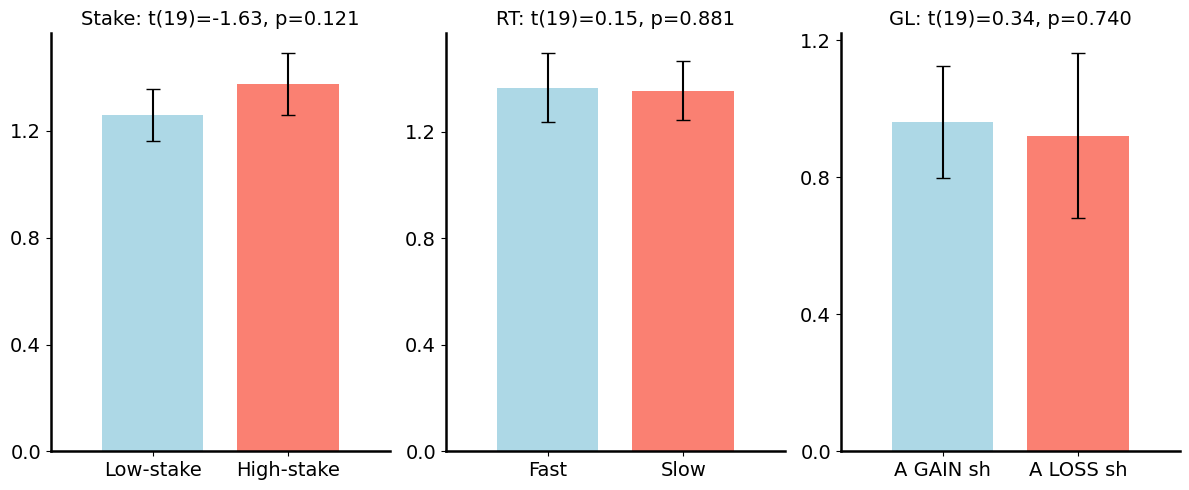

In [4]:
# ── PLOT 2×2 PAIRED BAR PLOTS ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(12, 5))
axes = axes.flatten()

for ax, name in zip(axes, t_stats.keys()):
    mu      = means[name]
    se      = sems[name]
    lab     = labels[name]
    t, df, p, cohen_d = t_stats[name]

    x = [0.3, 0.7]
    ax.bar(x, mu, yerr=se, capsize=5, color=['lightblue','salmon'], width=0.3)
    ax.set_xticks(x)
    ax.set_xlim(0, 1.0)
    # ax.set_ylim(0, (max(mu)+max(se))*1.2)
    ax.set_xticklabels(lab, rotation=0, fontsize=12)
    # ax.set_ylabel("Signal Change", fontsize=12)
    ax.set_title(f"{name}: t({df})={t:.2f}, p={p:.3f}", fontsize=14)
    ax.axhline(0, color='k', lw=0.8)
    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.8)  
    ax.spines['bottom'].set_linewidth(1.8)
    from matplotlib.ticker import MaxNLocator
    ax.yaxis.set_major_locator(MaxNLocator(4))  # Limits to 5 ticks on y-axis

plt.tight_layout()
# plt.show()

plt.savefig("output/roi_control_v1.png", dpi=300, bbox_inches='tight')
print("++ save fig to the server")

++ saved fig to output/roi_control_v1_violin_slope.png


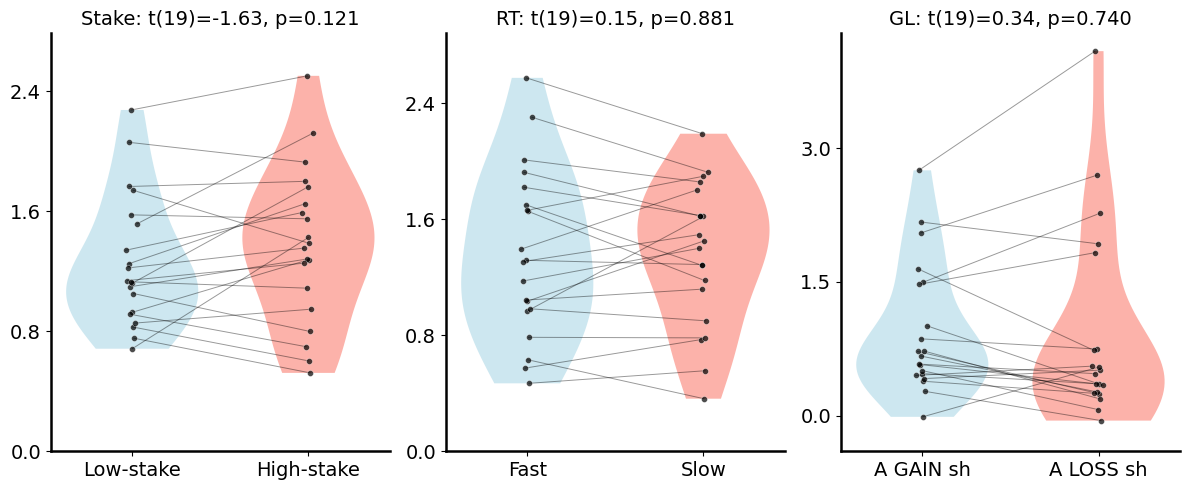

In [14]:
# %% Violin + paired slope for control V1 across contrasts (Stake, RT, GL)
import numpy as np, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import t

fig, axes = plt.subplots(1, len(pairs), figsize=(12, 5), sharey=False)
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

gain_color, loss_color = 'lightblue', 'salmon'
JITTER_SD = 0.02

# Keep contrast order consistent with your 'analyses' dict
names = [k for k in analyses.keys() if k in pairs]

for ax, name in zip(axes, names):
    pair = pairs[name]            # shape (2, n_subj)
    lab  = labels[name]           # e.g., ['Low-stake','High-stake'] etc.
    tval, df, pval, _ = t_stats[name]
    a = np.asarray(pair[0, :], float)
    b = np.asarray(pair[1, :], float)

    # background violins
    parts = ax.violinplot([a, b],
                          positions=[0, 1], widths=0.75,
                          showmeans=False, showmedians=False, showextrema=False)
    parts['bodies'][0].set_facecolor(gain_color); parts['bodies'][0].set_alpha(0.6); parts['bodies'][0].set_edgecolor('none')
    parts['bodies'][1].set_facecolor(loss_color); parts['bodies'][1].set_alpha(0.6); parts['bodies'][1].set_edgecolor('none')

    # paired slope lines + dots (use SAME jitter so lines hit both dots)
    rng = np.random.default_rng(7)
    mask = np.isfinite(a) & np.isfinite(b)
    a, b = a[mask], b[mask]
    base = rng.normal(0, JITTER_SD, size=a.size)
    xa, xb = 0 + base, 1 + base

    # lines under points
    for x0, x1, y0, y1 in zip(xa, xb, a, b):
        ax.plot([x0, x1], [y0, y1], color='k', alpha=0.4, lw=0.7, zorder=4)

    # dots
    ax.scatter(xa, a, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)
    ax.scatter(xb, b, s=18, alpha=0.7, color='k', linewidth=0.3, edgecolor='white', zorder=5)

    # per-axis y-limits (robust, with padding)
    y = np.concatenate([a, b])
    if y.size:
        lo, hi = np.percentile(y, [1, 99])
        pad = 0.2 * (hi - lo if hi > lo else 1.0)
        ax.set_ylim(min(lo - pad/2,0), hi + pad)

    # cosmetics & labels
    ax.set_xticks([0, 1])
    ax.set_xticklabels(lab, rotation=0, fontsize=12)
    ax.set_title(f"{name}: t({df})={tval:.2f}, p={pval:.3f}", fontsize=14)
    # ax.axhline(0, color='k', lw=0.8, alpha=0.8)
    ax.tick_params(axis='y', labelsize=14); ax.tick_params(axis='x', labelsize=14)
    for s in ['top', 'right']: ax.spines[s].set_visible(False)
    ax.spines['left'].set_linewidth(1.8); ax.spines['bottom'].set_linewidth(1.8)
    ax.yaxis.set_major_locator(MaxNLocator(4))

plt.tight_layout()
plt.savefig("output/roi_control_v1_violin_slope.png", dpi=300, bbox_inches='tight')
print("++ saved fig to output/roi_control_v1_violin_slope.png")